##  B&eacute;zier triangular patches defined as Plotly trisurfs ##

One year ago we presented [here](http://nbviewer.jupyter.org/github/empet/Geometric-Modeling/blob/master/Bezier-triangular-patch-in-plotly.ipynb) a method for visualizing B&eacute;zier  triangular surfaces  via Python Plotly. Since at that time Plotly could plot only rectangular patches we devised a tricky method to associate a rectangular meshgrid to a  triangulation. Now Plotly can plot trisurfs, and here we present how we triangulate the parameter domain of a triangular patch in order to plot it as a trisurf.

The new method is based on  the theoretical presentation of B&eacute;zier triangular surfaces made in the previous notebook.

In [1]:
import numpy as np
from __future__ import division

Below we define functions that perform the triangulation of the equilateral triangle $\Delta$, in $\mathbb{R}^3$, of vertices $(0,0,1)$, $(1,0,0)$, $(0,1,0)$. Unlike the triangulation method provided by `matplotlib.tri`, we define a triangulation that returns the barycentric coordinates of vertices, not the cartesian ones.

The `triangulate` function called for an integer `p` returns the  vertices of a triangulation having $p+1$ points on each side of the triangle $\Delta$,   `simplices` returns the indices corresponding to vertices that form the unfilled triangles in the image below, while `simplicesCompl` returns the indices corresponding to vertices of filled triangles:

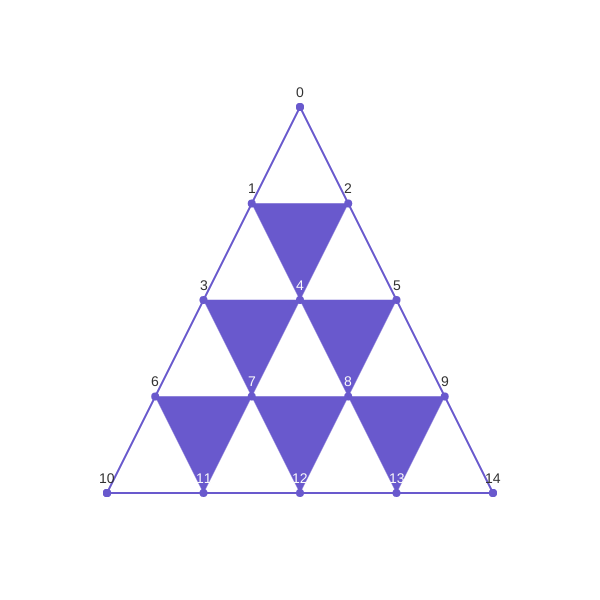

In [2]:
from IPython.display import Image
Image(filename='Imag/triangulgroups.png')

In [3]:
def triangulate(p):
    I=range(p, -1, -1)
    return [(i/p,j/p, 1-(i+j)/p) for i in I for j in range(p-i, -1, -1)]

def simplices(p):
    
    triplets=[]
    i=0
    j=1
    for nr in range(1,p+1):
        for k in range(nr):
            triplets.append([i,j,j+1])
            i+=1
            j+=1
        j+=1
    return np.array(triplets).reshape((len(triplets), 3)) 

In [4]:
def simplicesCompl(p):
    
    triplets=[]
    i=1
    j=2
    t=4
    m=2
    for nr in range(1,p):
        for k in range(nr):
            triplets.append([i,j,t])
            if k<nr-1:
                i=i+1
                j=j+1
                t+=1
        i=j+1
        j=i+1
        t=t+nr+m
        m-=1
    return np.array(triplets).reshape((len(triplets), 3)) 

In [5]:
def simplicesAll(p):# a function that returns all simplices returned by both functions above
    
    triplets=[]
    i=0
    j=1
    for nr in range(1,p+1):
        for k in range(nr):
            triplets.append([i,j,j+1])
            i+=1
            j+=1
        j+=1
    i=1
    j=2
    t=4
    m=2
    for nr in range(1,p):
        for k in range(nr):
            triplets.append([i,j,t])
            if k<nr-1:
                i=i+1
                j=j+1
                t+=1
        i=j+1
        j=i+1
        t=t+nr+m
        m-=1    
    return np.array(triplets).reshape((len(triplets), 3)) 

A point of the triangular surface is evaluated according to the [triangular de Casteljau algorithm](http://nbviewer.jupyter.org/github/empet/Geometric-Modeling/blob/master/Bezier-triangular-patch-in-plotly.ipynb).

In [6]:
def deCasteljau_step(n, b, lam):
    #n is the polynomial degree of the surface
    # b is the list of control points
    #lam is a triplet representing baricentric coordinates of a point in the associated 
    #triangulation of Delta
    i=0
    j=1
    for nr in range(1, n+1):
        for k in range(nr):
            b[i]=lam[0]*b[i]+lam[1]*b[j]+lam[2]*b[j+1]
            i+=1
            j+=1
        j+=1
    return b[:-(n+1)]

In [7]:
def deCasteljau(n,b,lam):
    #recursive function that returns a point on the triangular surface corresponding to
    #the barycentric coordinates [lam[0], lam[1], lam[2]
    
    if len(b)>1:       
        return deCasteljau(n-1, deCasteljau_step(n, b, lam), lam)   
    else: 
        return b[0]

To each point (triplet of barycentric coordinates) in a triangulation one associates a point on the B&eacute;zier patch. 

The following function discretizes a B&eacute;zier surface of degree `n`, control points `b`, and  triangulation vertices ( `barycenters`), defined  above:

In [8]:
def surface_points(n, b, barycenters):
    
    points=[]
    for weight in barycenters:
        b_aux=np.array(b)
        points.append(deCasteljau(n, b_aux, weight))
    return zip(*points)    

 `set_data_for_Surface` prepare data for a plot:

In [9]:
def set_data_for_Surface(n, b, p):
    
    if len(b)!=(n+1)*(n+2)/2:
        raise ValueError('incorect number of control points')
    barycenters=triangulate(p)
    
    x,y,z=surface_points(n, b, barycenters   )
    return x,y, z

In [10]:
def map_z2color(zval, cmap, vmin, vmax):
    #map the normalized value zval to a corresponding color in the colormap cmap
    
    if vmin>=vmax:
        raise ValueError('incorrect relation between vmin and vmax')
    t=(zval-vmin)/float((vmax-vmin))#normalize val
    C=map(np.uint8, np.array(cmap(t)[:3])*255)
    return 'rgb'+str((C[0], C[1], C[2]))
    

def tri_indices(simplices):
    #simplices is a numpy array defining the simplices of the triangulation
    #returns the lists of indices i, j, k
     
    return ([triplet[c] for triplet in simplices] for c in range(3))

In [11]:
import plotly.plotly as py
from plotly.graph_objs import *
import matplotlib.cm as cm
import plotly
plotly.offline.init_notebook_mode() 

In [12]:
def plotly_trisurf(x, y, z, simplices, colormap=cm.RdBu):
    #x, y, z are lists of coordinates of the triangle vertices 
    #simplices are the simplices that define the triangulation;
    #simplices  is a numpy array of shape (no_triangles, 3)
    #insert here the  type check for input data
    
    points3D=np.vstack((x,y,z)).T
    tri_vertices= points3D[simplices]# vertices of the surface triangles     
    zmean=[np.mean(tri[:,2]) for tri in tri_vertices ]# mean values of z-coordinates of 
                                                      #triangle vertices
    min_zmean=np.min(zmean)
    max_zmean=np.max(zmean)  
    facecolor=[map_z2color(zz,  colormap, min_zmean, max_zmean) for zz in zmean] 
    I,J,K=tri_indices(simplices)
    
    triangles=Mesh3d(x=x,
                     y=y,
                     z=z,
                     facecolor=facecolor, 
                     i=I,
                     j=J,
                     k=K,
                     name=''
                    )
    
    
    return triangles
    

Function that plots triangles with a color not a colormap:

In [13]:
def plotly_trisurf_color(x, y, z, simplices, color):
    #x, y, z are lists of coordinates of the triangle vertices 
    #simplices are the simplices that define the triangulation;
    #simplices  is a numpy array of shape (no_triangles, 3)
     
    facecolor=[color]*simplices.shape[0]
    I,J,K=tri_indices(simplices)
    triangles=Mesh3d(x=x,
                     y=y,
                     z=z,
                     facecolor=facecolor, 
                     i=I,
                     j=J,
                     k=K,
                     name=''
                    )
    
    
    return triangles

We plot three  surfaces corresponding to the same input data (B&eacute;zier control points), with the global triangulation, complementary triangulations colored distinctly, complementary triangulations colored with the same colorscale:

In [14]:
n=3
b=[[0,5.0, 3.0],
   [-1.2, 4, 4.4],
   [ 1.7, 3.0, 4.6],
   [-2.3, 2.8, 6.0],
   [-0.5, 2.5, 5.2],
   [2.8,2, 6.25],
   [-3.8,0, 4.2],
   [-1.8, -0.63, 3.17],
   [1.9,1.0, 3.0],
   [3.5, 0.2, 5.8 ]]
p=40

In [15]:
x,y,z=set_data_for_Surface(n, b, p)
tr=plotly_trisurf(x, y, z, simplicesAll(p), colormap=cm.viridis)
data=Data([tr])

In [16]:
axis = dict(
showbackground=True, 
backgroundcolor="rgb(230, 230,230)",
gridcolor="rgb(255, 255, 255)",      
zerolinecolor="rgb(255, 255, 255)",  
    )

layout = Layout(
         title='Bezier triangular patch defined as a trisurf',
         width=800,
         height=800,
         showlegend=False,
         scene=Scene(xaxis=XAxis(axis),
                     yaxis=YAxis(axis), 
                     zaxis=ZAxis(axis), 
                     aspectratio=dict(x=1,
                                      y=1,
                                      z=1
                                     ),
                    )
        )

fig = Figure(data=data, layout=layout)

In [17]:
plotly.offline.iplot(fig)

In [19]:
trace1=plotly_trisurf_color(x, y, z, simplices(p), color='blue')
trace2=plotly_trisurf_color(x, y, z, simplicesCompl(p), color='white')
data1=Data([trace1, trace2])

In [20]:


fig1 = Figure(data=data1, layout=layout)
fig1['layout'].update(title='Bezier triangular patch defined as a trisurf with interleaved colors')

In [21]:

plotly.offline.iplot(fig1)

Finally we plot the surface defined by two Plotly Surface instances: one for the simplices corresponding to unfilled triangles in the image above, and another for
    the simplices representing the filled triangles:

In [23]:
trace3=plotly_trisurf(x, y, z, simplices(p), colormap=cm.viridis)
trace4=plotly_trisurf(x, y, z, simplicesCompl(p), colormap=cm.viridis)
data2=Data([trace3, trace4])
fig2 = Figure(data=data2, layout=layout)
fig2['layout'].update(title='Bezier triangular patch defined as a trisurf')
plotly.offline.iplot(fig2)

In [24]:
from IPython.core.display import HTML
def  css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()